# Train a scVI model using Census data

This notebook demonstrates a scalable approach to training an [scVI](https://docs.scvi-tools.org/en/latest/user_guide/models/scvi.html) model on Census data. The [scvi-tools](https://scvi-tools.org/) library is built around [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/). [TileDB-SOMA-ML](https://github.com/single-cell-data/TileDB-SOMA-ML) assists with streaming Census query results to PyTorch in batches, allowing for training datasets larger than available RAM.

## Plan for this tutorial

1. Training the model
2. Generate cell embeddings
3. Analyzing the results

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


## Training the model 

Let's start by importing the necessary dependencies.

In [2]:
import warnings

import cellxgene_census
import numpy as np
import scanpy as sc
import scvi
import tiledbsoma as soma
from cellxgene_census.experimental.pp import highly_variable_genes

# from lightning import LightningDataModule
# from sklearn.preprocessing import LabelEncoder
# from torch.utils.data import DataLoader
from scvi.dataloaders import TileDBDataModule

warnings.filterwarnings("ignore")

→ connected lamindb: anonymous/lamindb_collection


We'll now prepare the necessary parameters for running a training pass of the model.

For this notebook, we'll use a stable version of the Census:

In [3]:
census = cellxgene_census.open_soma(census_version="2023-12-15")

We'll also do two types of filtering.

For **cells**, we will apply a filter to only select primary cells, with at least 300 expressed genes (nnz >= 300). For notebook demonstration purposes, we will also apply a tissue filtering so that the training can happen on a laptop. The same approach can be used on datasets much larger than available RAM. (A GPU is recommended, though.)

For **genes**, we will apply a filter so that only the top 8000 highly variable genes (HVG) are included in the training. This is a commonly used dimensionality reduction approach and is recommended on production models as well.

Let's define a few parameters:

In [4]:
experiment_name = "mus_musculus"
# obs_val_filt = ('is_primary_data == True and tissue_general in ["spleen", "kidney"] '
#            'and nnz >= 500')
obs_val_filt = (
    'is_primary_data == True and tissue_general in ["kidney"] '
    'and nnz >= 500 and donor_id not in ["pooled"]'
)
# obs_val_filt = ('is_primary_data == True and tissue_general in ["liver", "heart"] '
#            'and nnz >= 500')
top_n_hvg = 1000
hvg_batch = ["dataset_id", "donor_id"]

For HVG, we can use the `highly_variable_genes` function provided in `cellxgene_census`, which can compute HVGs in constant memory:

In [5]:
hvgs_df = highly_variable_genes(
    census["census_data"][experiment_name].axis_query(
        measurement_name="RNA", obs_query=soma.AxisQuery(value_filter=obs_val_filt)
    ),
    n_top_genes=top_n_hvg,
    batch_key=hvg_batch,
)
hv = hvgs_df.highly_variable
hv_idx = hv[hv].index
# hv_idx = np.arange(10)

Once we know the id's of the HVG's we can select only them using the tiledb query mechanism

In [6]:
hvg_query = census["census_data"][experiment_name].axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(value_filter=obs_val_filt),
    var_query=soma.AxisQuery(coords=(list(hv_idx),)),
)

We define the batch to be a multivariate parameters

In [7]:
batch_keys = ["dataset_id", "donor_id"]

We will now introduce a helper class `TileDBDataModule` to connect SCVI with TileDB-SOMA-ML with PyTorch Lightning. It subclasses [`LightningDataModule`](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) and:

1. Uses TileDB-SOMA-ML to prepare a DataLoader for the results of a SOMA [`ExperimentAxisQuery`](https://tiledbsoma.readthedocs.io/en/1.15.0/python-tiledbsoma-experimentaxisquery.html) on the Census.
1. Derives each cell's scVI batch label as a tuple of obs attributes: `dataset_id`, `donor_id`.
    * *Don't confuse each cell's label for scVI "batch" integration with a training data "batch" generated by the DataLoader.*
1. Converts the RNA counts and batch labels to a dict of tensors for each training data batch, as scVI expects.

In [8]:
datamodule = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_size=1024,
    shuffle=True,
    seed=42,
    batch_column_names=batch_keys,
    dataloader_kwargs={"num_workers": 64, "persistent_workers": False},
    accelerator="gpu",
    device=1,
    return_sparse_X=False,
)
print(datamodule.n_obs, datamodule.n_vars, datamodule.n_batch)

46464 1000 37


Most parameters to `TileDBDataModule` are passed through to the [`tiledbsoma_ml.ExperimentDataset`](https://single-cell-data.github.io/TileDB-SOMA-ML/#tiledbsoma_ml.ExperimentDataset) initializer; see that documentation to understand how it can be tuned.

In particular, here are some parameters of interest:

* `shuffle`: shuffles the result cell order, which is often advisable for model training.
* `batch_size`: controls the size (number of cells) in each training data batch, in turn controlling memory usage.
* `dataloader_kwargs`: [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) tuning, for example controlling parallelization.

We can now create the scVI model object:

In [9]:
n_layers = 1
n_latent = 10
datamodule.setup()
model = scvi.model.SCVI(
    adata=None,
    registry=datamodule.registry,
    n_layers=n_layers,
    n_latent=n_latent,
    gene_likelihood="nb",
    encode_covariates=False,
)

In [10]:
# creating the dataloader for trainset
training_dataloader = (
    datamodule.on_before_batch_transfer(batch, None) for batch in datamodule.train_dataloader()
)

switching torch multiprocessing start method from "fork" to "spawn"


Then, we can invoke the `.train` method which will start the training loop.

In [11]:
import time

start = time.time()
model.train(
    datamodule=training_dataloader,
    # datamodule=datamodule,
    max_epochs=100,
    batch_size=1024,
    # accelerator="gpu",
    # devices=-1,
    # strategy="ddp_find_unused_parameters_true",
)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 87.88 seconds


We can now save the trained model. As of the current writing, scvi-tools doesn't support saving a model that wasn't generated through an AnnData loader, so we'll use some custom code:

In [12]:
model.save("census_model", save_anndata=False, overwrite=True, datamodule=datamodule)

We will now load the model back and use it to generate cell embeddings (the latent space), which can then be used for further analysis. Loading the model similarly involves some custom code.

In [13]:
scvi.model.SCVI.load("census_model", adata=False)

INFO     File census_model/model.pt already downloaded                                                             


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

## Generate cell embeddings

We will now generate the cell embeddings for this model, using the `get_latent_representation` function available in scvi-tools. 

We can use another instance of the `SCVIDataModule` for the forward pass, so we don't need to load the whole dataset in memory. This will have shuffling disabled to make it easier to join the embeddings later. We also want to restore the list of scVI batch labels from the training data, ensuring our forward pass will map batch labels to tensors in the expected way (although this specific example would work regardless, since it reuses the same query).

In [14]:
inference_datamodule = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_labels=datamodule.batch_labels,
    batch_size=1024,
    shuffle=False,
    batch_column_names=batch_keys,
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
)

To feed the data to `get_latent_representation`, we operate `inference_datamodule` as PyTorch Lightning would during training:

In [15]:
inference_datamodule.setup()
inference_dataloader = (
    inference_datamodule.on_before_batch_transfer(batch, None)
    for batch in inference_datamodule.train_dataloader()
)
latent = model.get_latent_representation(dataloader=inference_dataloader)
latent.shape

(46464, 10)

We successfully trained the model and generated embeddings using limited memory. Even on the full Census, this has been tested to run with less than 30G of memory.

## Analyzing the results

We will now take a look at the UMAP for the generated embedding. Note that we need to extract the adata out of the census data.

In order to do this, we'll use `scanpy` which accepts an AnnData object, so we'll generate one using the `get_anndata` utility function:

In [16]:
adata = cellxgene_census.get_anndata(
    census,
    organism=experiment_name,
    obs_value_filter=obs_val_filt,
)

Add the generated embedding (stored in `latent`) in the obsm slot of the AnnData object:

In [17]:
# verify cell order:
assert np.array_equal(
    np.array(adata.obs["soma_joinid"]), inference_datamodule.train_dataset.query_ids.obs_joinids
)

adata.obsm["scvi"] = latent

We can now generate the neighbors and the UMAP.

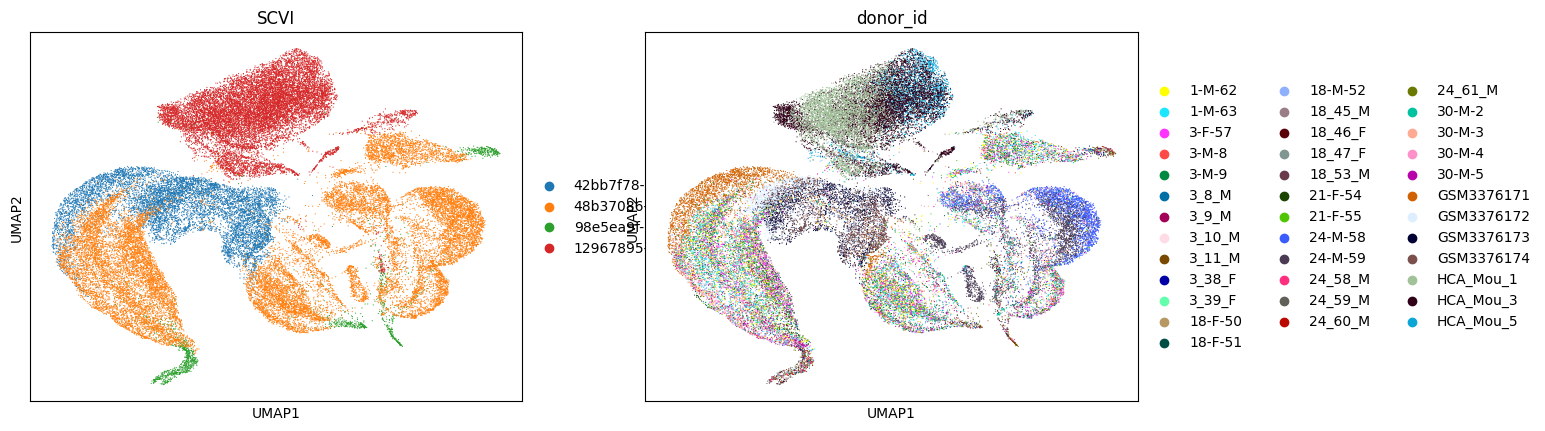

In [18]:
sc.pp.neighbors(adata, use_rep="scvi", key_added="scvi")
sc.tl.umap(adata, neighbors_key="scvi")
sc.pl.umap(adata, color=["dataset_id", "donor_id"], title="SCVI")

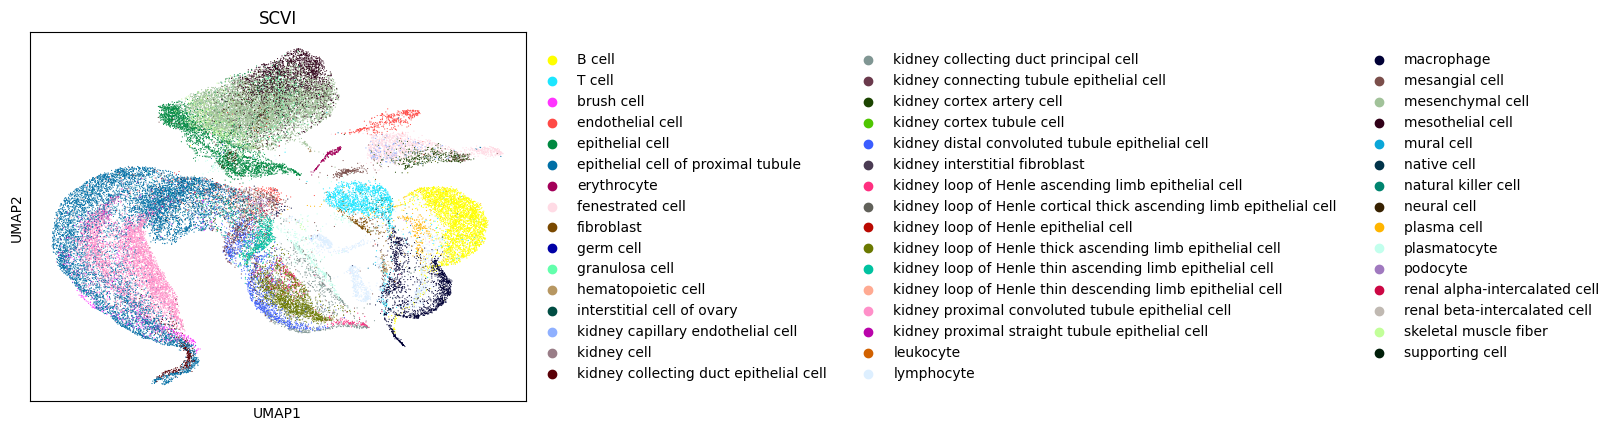

In [19]:
sc.pl.umap(adata, color="cell_type", title="SCVI")

In [20]:
# sc.pl.umap(adata, color="tissue_general", title="SCVI")

lets train the actual adata that we extracted the normal way in order to see the integration 

In [21]:
adata.obs["batch"] = adata.obs[batch_keys].agg("//".join, axis=1).astype("category")

In [22]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch")

In [23]:
# model_census3 = scvi.model.SCVI.load("census_model", adata=adata)
model_census3 = scvi.model.SCVI(adata)

In [24]:
start2 = time.time()
model_census3.train(
    max_epochs=100,
)
end2 = time.time()
print(f"Elapsed time: {end2 - start2:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 377.11 seconds


In [25]:
adata.obsm["scvi_non_dataloder"] = model_census3.get_latent_representation()

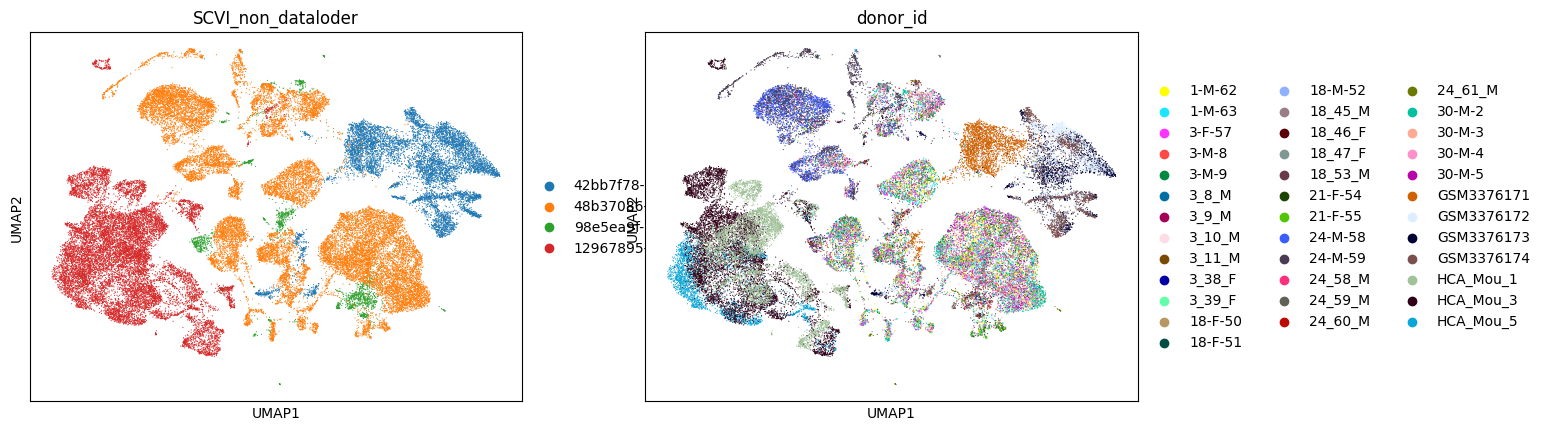

In [26]:
sc.pp.neighbors(adata, use_rep="scvi_non_dataloder", key_added="scvi_non_dataloder")
sc.tl.umap(adata, neighbors_key="scvi_non_dataloder")
sc.pl.umap(adata, color=["dataset_id", "donor_id"], title="SCVI_non_dataloder")

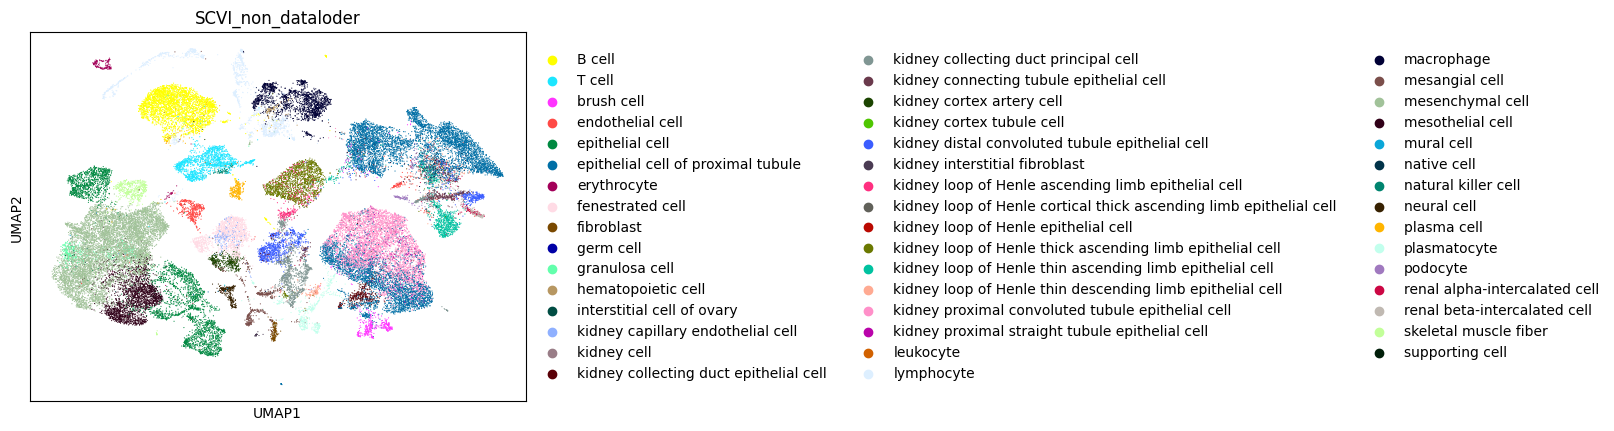

In [27]:
sc.pl.umap(adata, color="cell_type", title="SCVI_non_dataloder")

In [28]:
# sc.pl.umap(adata, color="tissue_general", title="SCVI_non_dataloder")

REPEAT TO SCANVI

In [29]:
label_keys = ["cell_type"]
datamodule_scanvi = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_size=8192,
    shuffle=True,
    seed=42,
    batch_column_names=batch_keys,
    label_keys=label_keys,
    unlabeled_category="label_0",
    dataloader_kwargs={"num_workers": 12, "persistent_workers": False},
)
print(datamodule_scanvi.n_obs, datamodule_scanvi.n_vars, datamodule_scanvi.n_batch)

46464 1000 37


In [30]:
# We can now create the scVI model object and train it:
datamodule_scanvi.setup()
model_scanvi = scvi.model.SCANVI(
    adata=None,
    registry=datamodule_scanvi.registry,
    n_layers=n_layers,
    n_latent=n_latent,
    gene_likelihood="nb",
    encode_covariates=False,
    datamodule=datamodule_scanvi,
)

In [31]:
# creating the dataloader for trainset
training_scanvi_dataloader = (
    datamodule_scanvi.on_before_batch_transfer(batch, None)
    for batch in datamodule_scanvi.train_dataloader()
)

In [32]:
start3 = time.time()
model_scanvi.train(
    datamodule=training_scanvi_dataloader,
    max_epochs=100,
    batch_size=8192,
)
end3 = time.time()
print(f"Elapsed time: {end3 - start3:.2f} seconds")

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 114.84 seconds


In [34]:
# model_scanvi.save(
#    "census_model_scanvi", save_anndata=False, overwrite=True, datamodule=datamodule_scanvi
# )

In [35]:
# Generate cell embeddings
inference_datamodule = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_labels=datamodule_scanvi.batch_labels,
    batch_size=8192,
    shuffle=False,
    batch_column_names=batch_keys,
    label_keys=label_keys,
    unlabeled_category="label_0",
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
)

In [36]:
inference_datamodule.setup()
inference_dataloader = (
    inference_datamodule.on_before_batch_transfer(batch, None)
    for batch in inference_datamodule.train_dataloader()
)
latent_scanvi = model_scanvi.get_latent_representation(dataloader=inference_dataloader)
latent_scanvi.shape

(46464, 10)

In [37]:
adata.obsm["scanvi"] = latent_scanvi

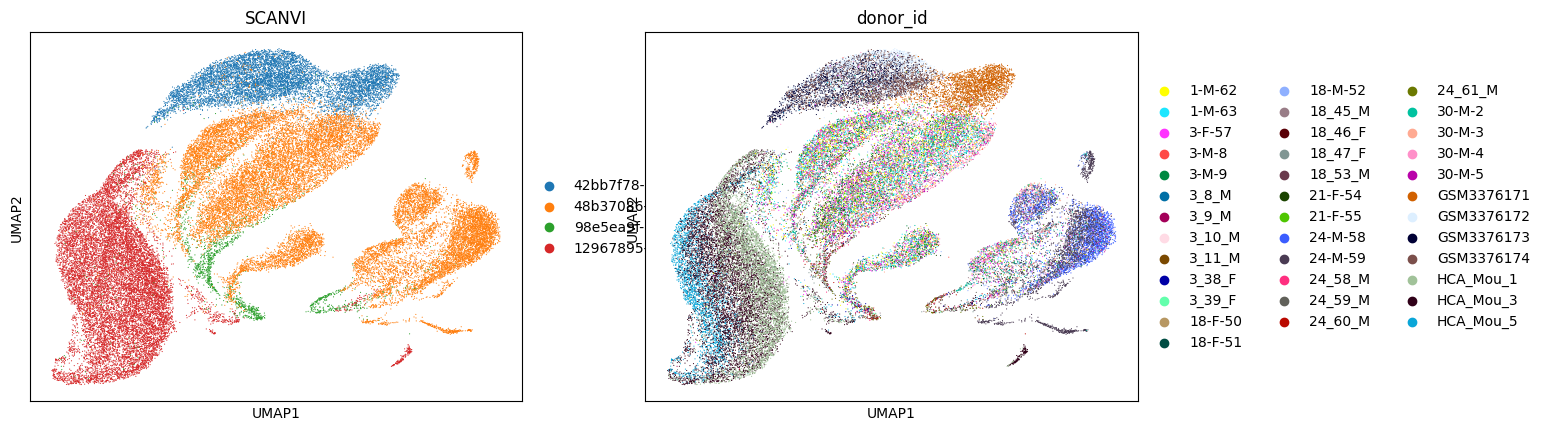

In [38]:
sc.pp.neighbors(adata, use_rep="scanvi", key_added="scanvi")
sc.tl.umap(adata, neighbors_key="scanvi")
sc.pl.umap(adata, color=["dataset_id", "donor_id"], title="SCANVI")

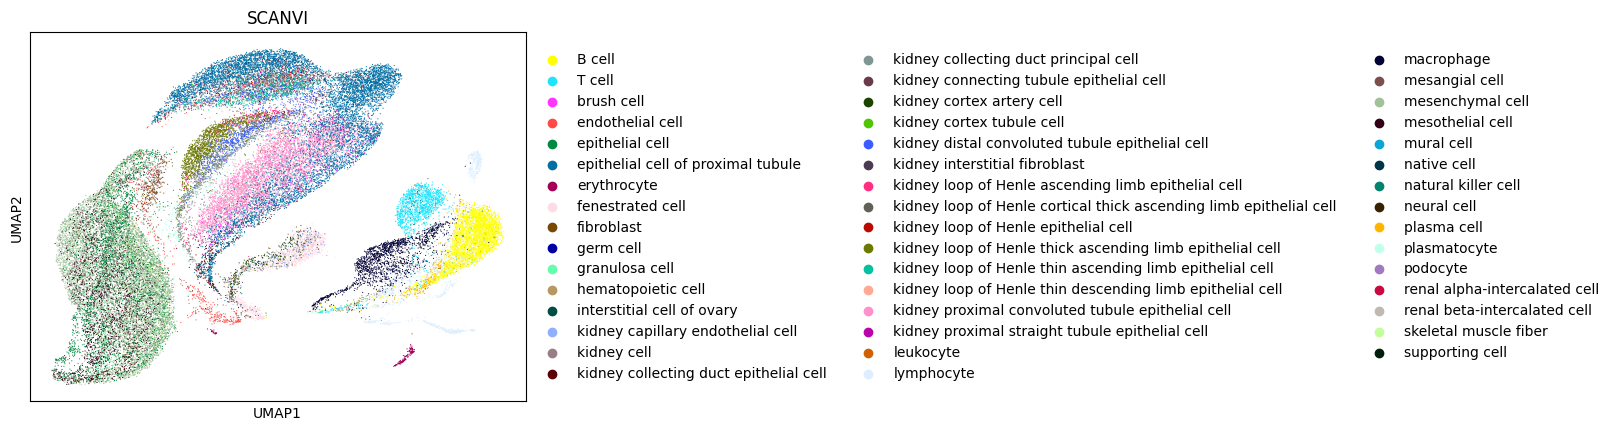

In [39]:
sc.pl.umap(adata, color="cell_type", title="SCANVI")

In [40]:
# sc.pl.umap(adata, color="tissue_general", title="SCANVI")